# Constraints

**Goal:** Understand how the conditional models *evolve* as a function of where we are in the zoomed massplane.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
from matplotlib import gridspec
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  


from sklearn.preprocessing import StandardScaler
from scipy.stats import binned_statistic_2d, chisquare
from scipy.stats import norm 

import os
os.sys.path.append('../code')
from plotting import SR_x, SR_y1, SR_y2
from eventDisplays import rainbow_text

import torch
from torch import nn
from torch.distributions import Normal, Categorical,OneHotCategorical

from mdn import MixtureDensityNetwork
from densityEstimate import *
from densityPlots import *

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


**Load in the data**

In [21]:
d = data()

# Add the 2b and deta_hh cuts
mh1_mask = (d.df.m_h1 > 126-45) & (d.df.m_h1 < 126+45)
mh2_mask = (d.df.m_h2 > 116-45) & (d.df.m_h2 < 116+45)
mask = mh1_mask & mh2_mask 

mask = mask & (d.df.abs_deta_hh < 1.5) & (d.df.ntag==2)

cols = ['log_m_hh_cor2','absCosThetaStar']
d.mlPrepare(mask,cols)

../data/data_16_PFlow-MAY2019-5jets/df_f_0.22_NNT_HCs.h5


## MDN

I'll look at the 4 mode MDN that I've been playing with and see how the predicted $\alpha_i$, $\mu_i$ and $\sigma_i$ vary depending on *where* we are in the massplane.

**Load in the MDN model**

In [80]:
import torch.nn.functional as F

In [71]:
K, H = 4, 100

subDir = f'{(d.subDir)}_2b_detaCut'

mdn = MDN(subDir,5e-3,0,['log_mhh_cor2'],0,K,H,load_model=True)
mp = MDN_Plots(mdn,save=True)     

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor2']


**Prepare the grid on conditioning points**

In [127]:
nb = 72

m1_edg = np.linspace(126-45,126+45,nb+1)
m2_edg = np.linspace(116-45,116+45,nb+1)

m1s = 0.5 * (m1_edg[1:] + m1_edg[:-1])
m2s = 0.5 * (m2_edg[1:] + m2_edg[:-1])

In [128]:
xx, yy = np.meshgrid(m1s,m2s)

xx = xx.ravel()
yy = yy.ravel()

But - I don't think `Y_SR` is even relevant for these studies rn, since I'm just trying to probe the predictions of the model.

In [129]:
Xi = np.vstack([xx,yy]).T
Yi = np.ones_like(Xi) # Just dummy values st I can apply the scalar

Apply the ml pre-processing

In [130]:
X = np.concatenate([Xi,Yi],axis=1)

X = d.scalar.transform(X)

Xi = torch.tensor(X[:,:2]).float()

In [131]:
pi, (mu,sigma) = mdn.model(Xi,True)

pi = F.softmax(pi,dim=1)

First - let's just sanity check that I understand how the unraveling works!

In [162]:
z = xx.reshape(nb,nb)[::-1]
im = plt.imshow(z,cmap=cmap,extent=[*m1_edg[[0,-1]],*m2_edg[[0,-1]]])


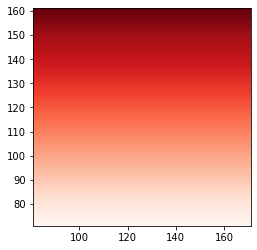

In [163]:
z = yy.reshape(nb,nb)[::-1]
im = plt.imshow(z,cmap=cmap,extent=[*m1_edg[[0,-1]],*m2_edg[[0,-1]]])

In [168]:
fig, axes = plt.subplots(K,3,figsize=(17,21))

for k, cmap in enumerate(['Blues','Oranges','Greens','Reds']):
    
    for j, v, var in zip(range(3),[pi, mu, sigma],[r'$\alpha_{}$','$\mu_{}$','$\sigma_{}$']):
        z = v[:,k].detach().numpy().reshape(nb,nb)[::-1]
        im = axes[k,j].imshow(z,cmap=cmap,extent=[*m1_edg[[0,-1]],*m2_edg[[0,-1]]])
        fig.colorbar(im, ax=axes[k,j])
        
        # Overlay SR
        axes[k,j].plot(SR_x, SR_y1, 'k')
        axes[k,j].plot(SR_x, SR_y2, 'k')
        
        # Add labels
        axes[k,j].set_xlabel('$m_{h1}$ [GeV]',fontsize=15)
        axes[k,j].set_ylabel('$m_{h2}$ [GeV]',fontsize=15)
        axes[k,j].set_title(var.format(k),fontsize=15)

plt.savefig(mp.figDir+'dist_params_massplane.pdf')

Interesting, could I identify the noisy shape of the bottom right plot with the non-closure I was seeing in the SR?

I.e, I could adjust the circle so that it was in the correct spot, and then plot?


I'd also be kind of interested in just looking at these for more of the models that I've trained to see if I converge to the same solution or not.

**Next step:** Plot the gradients of these images!

## R-NVP 2 vars

Ok, so for a 5 layer flow, each step scales and transforms another variable, so I think this would be a plot with 5 rows and 4 columns!

I think this plot will be clearer if each column stays for a particular variable, but there will be a lot of whitespace as well.


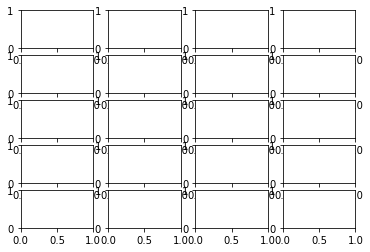

In [170]:
fig, axes = plt.subplots(5,4)

## R-NVP 5 vars